# Chapter 3. Classification

- Now we will turn our attention to classification systems.

## MNIST

- In this chapter we will be using MNIST
    - A dataset comprised of 70,000 small images
    - Images represent handwritten digits by students & employees from the US census Bureau.
- Each image is labeled with the digit it represents
    - Ranging from 0 to 9
        - 10 Digits
- Scikit-learn provides many helper functions to download popular datasets:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

In [3]:
from sklearn.datasets import fetch_openml

In [4]:
mnist = fetch_openml(name='mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

In [9]:
X, y = mnist['data'], mnist['target']
X.shape, y.shape

((70000, 784), (70000,))

In [10]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

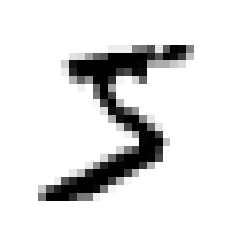

In [11]:
plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [12]:
y[0]

'5'

- Note that the label is a string, most algorithms expect numerical inputs so let's transform it:

In [13]:
y = y.astype(np.int8)

- But we should always start with splitting the data into train vs. test, right?

In [15]:
X_train, y_train, X_test, y_test = X[:60000], y[:60000], X[60000:], y[60000:]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 784), (60000,), (10000, 784), (10000,))

- Some ML algorithms are sensitive to ordered rows and can perform badly if instances from the same class are grouped together, the solution to this is to shuffle.
    - MNIST's training data is already shuffled for us.

## Training a Binary Classifier

- Let's simplify the problem for now and try to identify one digit (number **5**).
- This "5-detector" is an example of a binary classifier, it will predict, for any row, 5 or not-5.
- Let's create the target vector for the classification task:

In [25]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

- A good place to start is with a Stochastic Gradient Descent Classifier:

In [26]:
from sklearn.linear_model import SGDClassifier

In [27]:
sgd_clf = SGDClassifier(random_state=42)

In [28]:
sgd_clf.fit(X=X_train, y=y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

- Now we will use it to predict the digit of image at index 0:

In [29]:
sgd_clf.predict(X=[some_digit])

array([ True])

- .. and it's indeed a 5.
- Now let's evaluate this model's performance:

## Performance Measures

- Evaluating a classifier is often significantly trickier than evaluating a regressor.
- There are many performance measures available.

### Measuring Accuracy using Cross Validation

In [30]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [32]:
skfolds = StratifiedKFold(n_splits=3, random_state=42)

In [33]:
for train_index, test_index in skfolds.split(X=X_train, y=y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_5[test_index]
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    num_correct = sum(y_pred == y_test_folds)
    print(num_correct / len(y_pred))

0.95035
0.96035
0.9604


- Alternatively, let's use `cross_val_score()` function to do Kfold cross validation where $K=3$:

In [34]:
from sklearn.model_selection import cross_val_score

In [35]:
scores = cross_val_score(estimator=clone(sgd_clf), X=X_train, y=y_train_5, cv=3, scoring="accuracy")
scores

array([0.95035, 0.96035, 0.9604 ])

- Above $95%$ accuracy, isn't that great?
- Let's look at the performance of a very dumb classifier that classifies all training rows as "Not-5":

In [36]:
from sklearn.base import BaseEstimator

In [39]:
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    
    def predict(self, X):
        return np.zeros(shape=(len(X), 1), dtype=bool)

In [40]:
never_5_classifier = Never5Classifier()

In [41]:
scores = cross_val_score(estimator=never_5_classifier, X=X_train, y=y_train_5, cv=3, scoring="accuracy")
scores

array([0.91125, 0.90855, 0.90915])

- The dumb classifier has over 90% acccuracy for any validation.
- This hapenned because of the class imabalance in the binary task we are aiming for:
    - We originally had balanced counts for each digit.
    - But when we turned the problem into 5 vs. non-5, we end up with the first class taking ~10% of the rows and non-5 taking >=90%.
    - Hence, if you created a dumb model that just predicts "non-5" for any input, you'll get at least 90% accuracy.
- This demonstrates why accuracy is generally not the preferred method to evaluate classifiers, especially if the data have imbalanced classes.

### Confusion Matrix

- A much better way to evaluate the performance of a classifier is to look at its produced confusion matrix.
- Let's use `cross_val_predict()` to get some predictions to finally visualize the confusion matrix:

In [47]:
from sklearn.model_selection import cross_val_predict

In [48]:
y_train_pred = cross_val_predict(estimator=sgd_clf, X=X_train, y=y_train_5, cv=3)

In [49]:
y_train_pred.shape

(60000,)

- ...